In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
#from matplotlib import rcParam
import seaborn as sb
import os
import sys
sys.setrecursionlimit(1000000)
from scipy.stats import spearmanr
import pathlib
import scipy as sp
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache()
from scipy.stats import pearsonr
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import scanpy as sc
import anndata as ad

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/camp/home/turnerb/.conda/envs/MAPseq_proces

In [2]:
from matplotlib import rcParams
#for_binary_barcode_path = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/Sequencing/Processed_data/UpdatedApril/preprocessed_seq/Final_processed_sequences/filtered_barcode_matrix_for_binary_junk_test.pkl')
#normalised_barcode_path_junk_test = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/Sequencing/Processed_data/UpdatedApril/preprocessed_seq/Final_processed_sequences/barcode_matrix_normalised_junk_test.pkl')
normalised_barcode_path= pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/Source_target_together/source_filtered_thresholded_all_source.pkl')
#normalised_barcode_path= pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/Sequencing/Processed_data/UpdatedApril/preprocessed_seq_corrected/Final_processed_sequences/barcode_matrix_normalised.pkl')
lcm_reg_dir = pathlib.PurePath('/nemo/lab/znamenskiyp/home/shared/code/MAPseq_processing/AC_MAPseq/Brain1_FIAA32.6a/LCM_registration')
areas = pd.read_csv(lcm_reg_dir/'3d_areas.csv')
RTtosample = pd.read_csv(lcm_reg_dir/'RTprimer_tosample.csv')
# areas = areas.merge(RTtosample, how='inner', on='sample')
#areas.sort_values("RT_primer", inplace=True)





In [3]:
#load barcodes, and drop samples that have been qc'd out
barcodes_across_sample = pd.read_pickle(normalised_barcode_path)

areas =areas[areas['sample'].isin(barcodes_across_sample.columns)]

In [9]:
#drop columns that are zero in all values
#barcodes_matrix = barcodes_across_sample.loc[:, (barcodes_across_sample != 0).any(axis=0)]

In [4]:
all_areas_fractions = pd.DataFrame(index=barcodes_across_sample.columns)
all_areas_fractions['name'] = 'string'
areas_to_look = areas.set_index('sample')
for i, row in areas_to_look.iterrows():
    row /= row.sum(0)
    
    if row[row.idxmax()]>0.9999:
        name= str(row.idxmax()) + ' ' + str(row[row.idxmax()].round(2))
    else:
        second_highest_row = row.drop(row.idxmax())
        name= str(row.idxmax()) + ' ' + str(row[row.idxmax()].round(2)) + ' ' + str(second_highest_row.idxmax()) + ' ' + str(row[second_highest_row.idxmax()].round(2))
    all_areas_fractions.loc[i] = name
    

In [60]:
normalised_with_source = barcodes_across_sample.div(barcodes_across_sample.max(axis=1), axis=0)

In [61]:
#now look only at the barcodes with max barcode count ipsi auditory regions and A1
A1_and_TEA = [35, 36, 42, 43, 51, 65]
source_thresholded = normalised_with_source[normalised_with_source.idxmax(axis=1).isin(A1_and_TEA)]

In [32]:
barcodes_across_sample_renamed = source_thresholded.copy() #note changed from barcodes_across_sample
new_columns= {}
for val in barcodes_across_sample_renamed.columns:
    new_columns[val]= all_areas_fractions.loc[val]['name'] #create a dictionary to rename columns in the barcode matrix with tube names rather than RT sample names
barcodes_across_sample_renamed = barcodes_across_sample_renamed.rename(columns=new_columns)

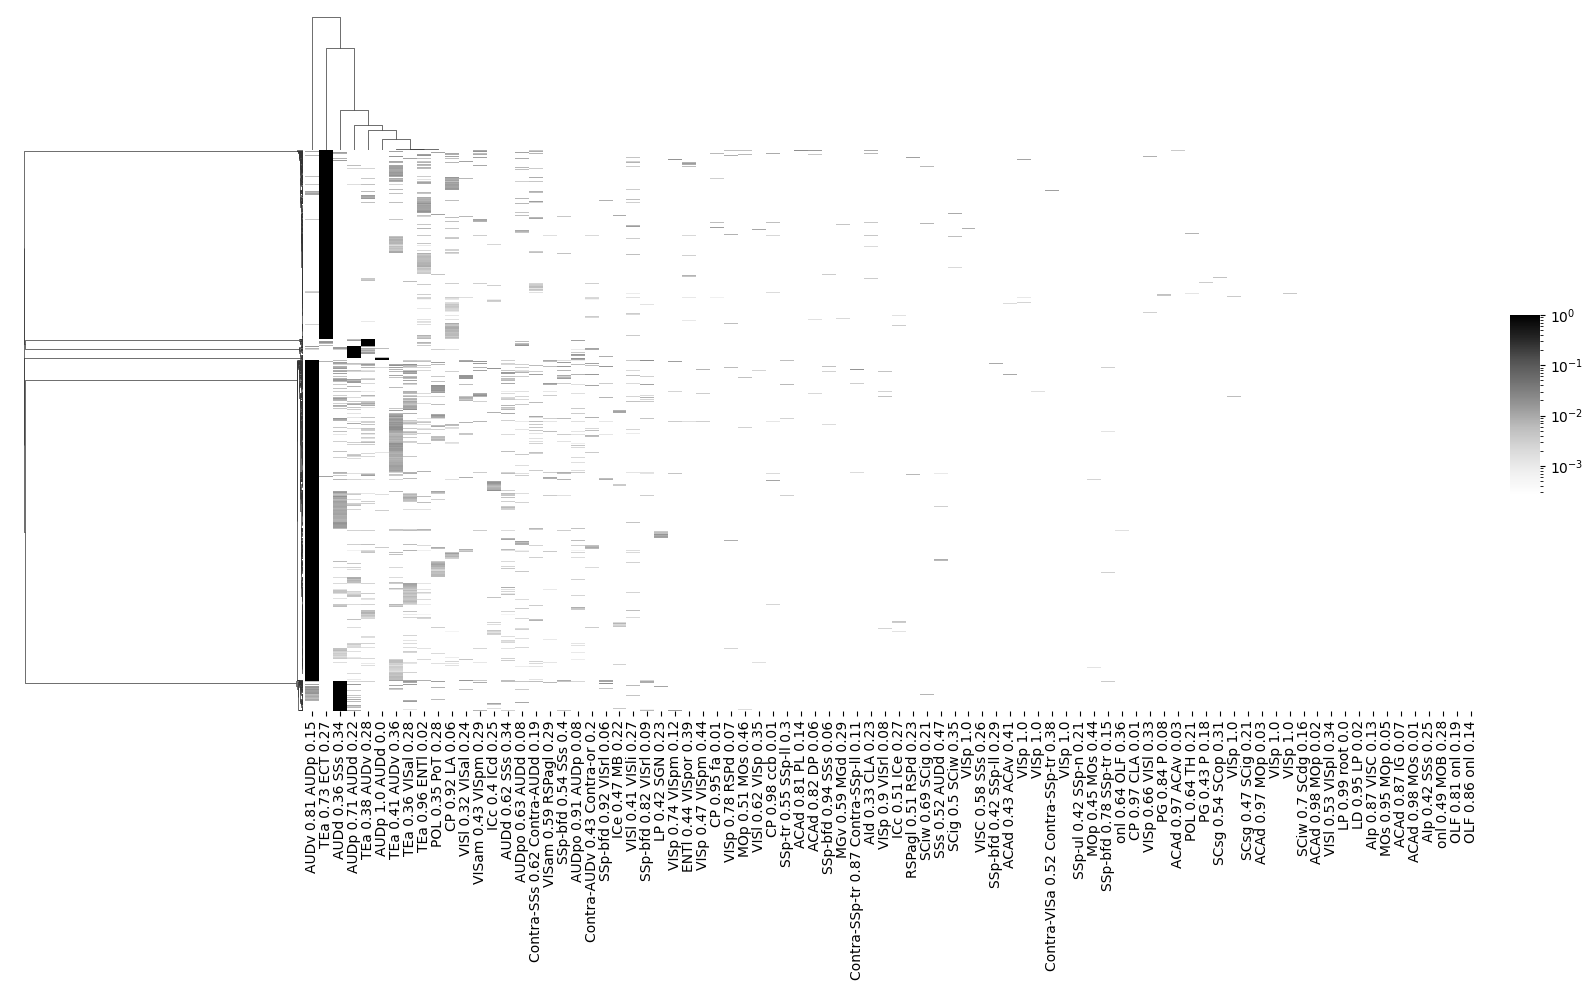

In [33]:
barcodes_across_sample_renamed_1 =barcodes_across_sample_renamed.reset_index(drop=True)
sb.clustermap(barcodes_across_sample_renamed_1, metric='euclidean', standard_scale=0, norm=LogNorm(), cmap="Greys", figsize=(15, 10), xticklabels=1 ,yticklabels=False, cbar_pos=(1.01, 0.5, 0.02, 0.18))

In [63]:
#have a look a connectivity with the source sites dropped.
barcodes_no_source = source_thresholded.drop(A1_and_TEA, axis=1)

In [64]:
#remove any rows and columns where all zeros
barcodes_no_source = barcodes_no_source.loc[:, (barcodes_no_source != 0).any(axis=0)]
barcodes_no_source = barcodes_no_source.loc[~(barcodes_no_source == 0).all(axis=1)]

In [36]:
barcodes_no_source_renamed = barcodes_no_source.copy()
new_columns= {}
for val in barcodes_no_source.columns:
    new_columns[val]= all_areas_fractions.loc[val]['name'] #create a dictionary to rename columns in the barcode matrix with tube names rather than RT sample names
barcodes_no_source_renamed = barcodes_no_source_renamed.rename(columns=new_columns)

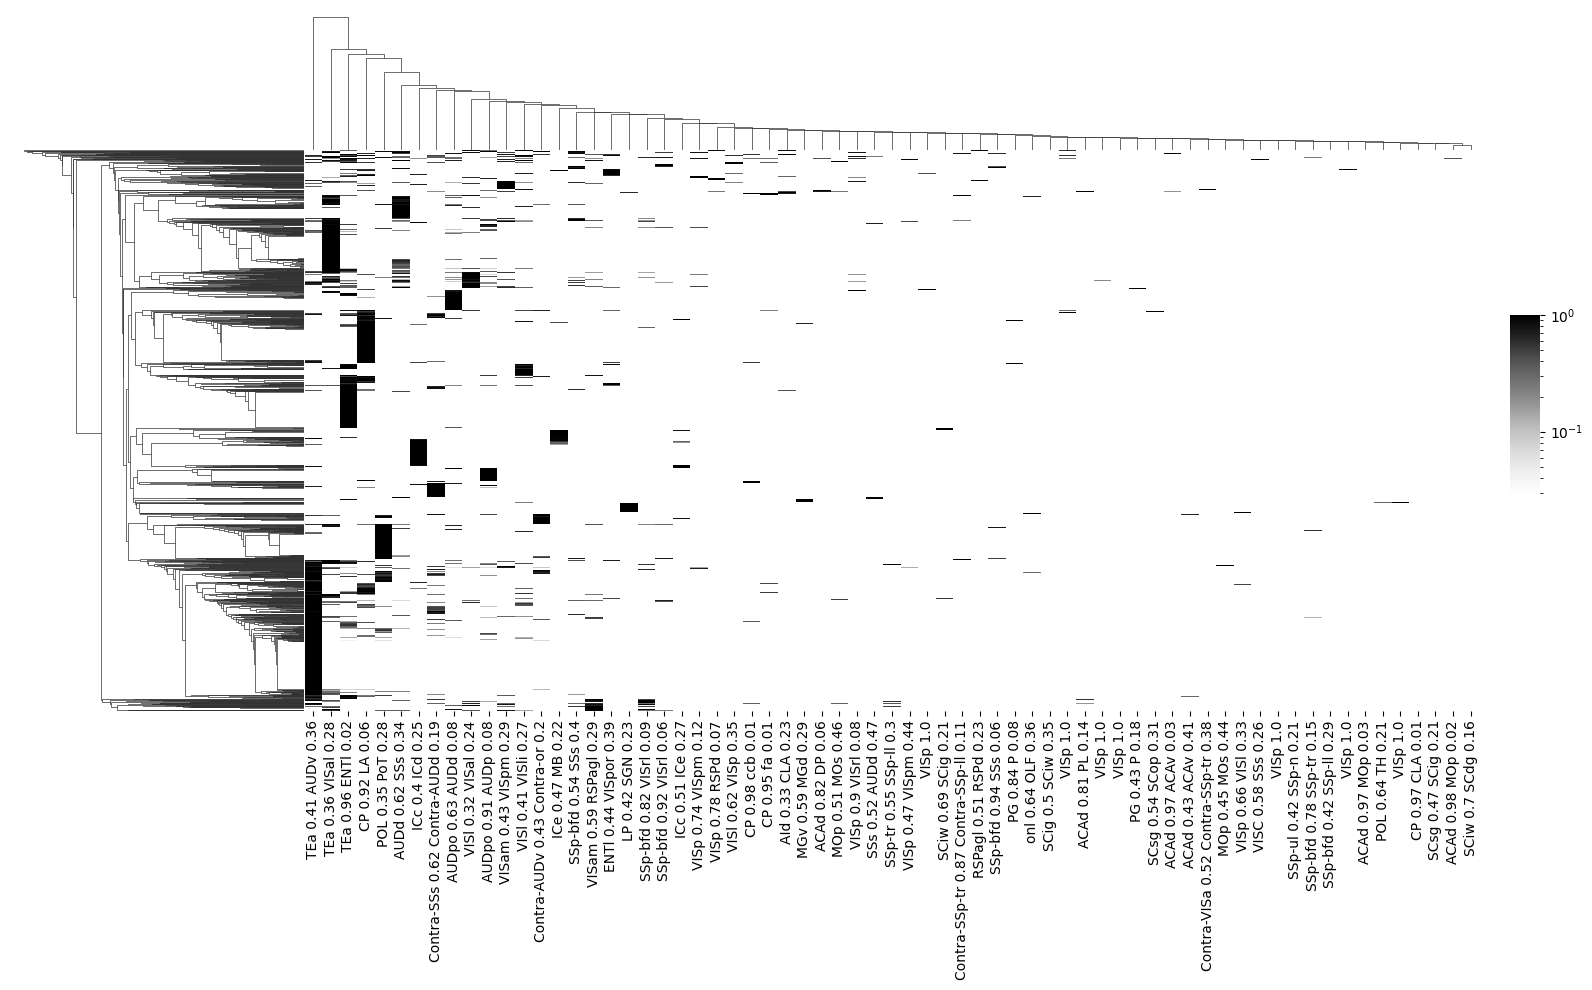

In [37]:
barcodes_no_source_renamed =barcodes_no_source_renamed.reset_index(drop=True)
sb.clustermap(barcodes_no_source_renamed, metric='euclidean', standard_scale=0, norm=LogNorm(), cmap="Greys", figsize=(15, 10), xticklabels=1 ,yticklabels=False, cbar_pos=(1.01, 0.5, 0.02, 0.18))

In [69]:
#now normalise remaining samples by their sum, so each value is a fraction of total without source sites
barcodes_normalised_no_source = barcodes_no_source.div(barcodes_no_source.sum(axis=1), axis=0)

In [70]:
#remove rows or columns with nothing in them afte rremoving source columns
barcodes_normalised_no_source= barcodes_normalised_no_source.loc[:, (barcodes_normalised_no_source != 0).any(axis=0)]
barcodes_normalised_no_source = barcodes_normalised_no_source.loc[~(barcodes_normalised_no_source == 0).all(axis=1)]

Lets use scampy to perform clustering using leiden algorithm

In [71]:
#drop the thalamus samples
barcodes_across_sample_no_thal = barcodes_normalised_no_source.drop([54, 56, 66, 67], axis=1)

In [72]:
dataset =ad.AnnData(barcodes_across_sample_no_thal)

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


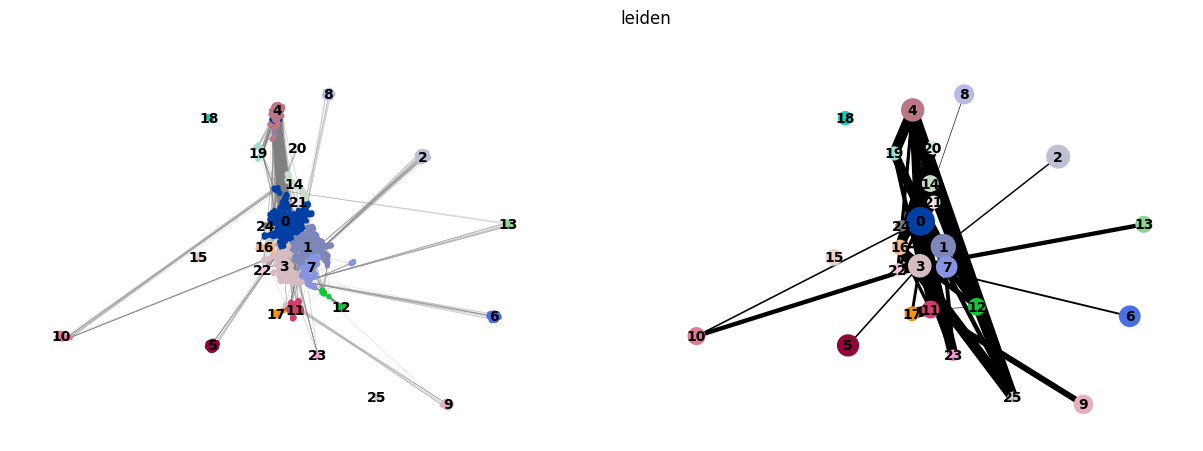

In [75]:
sc.tl.pca(dataset)
sc.pp.neighbors(dataset)
sc.tl.umap(dataset)
sc.tl.leiden(dataset)
sc.tl.paga(dataset)
sc.pl.paga_compare(dataset, edges=True, threshold=0.05)

In [76]:
sc.tl.leiden(dataset, key_added = "leiden_1.0") 

In [78]:
sc.tl.leiden(dataset, resolution = 0.6, key_added = "leiden_0.6")
sc.tl.leiden(dataset, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(dataset, resolution = 1.4, key_added = "leiden_1.4")

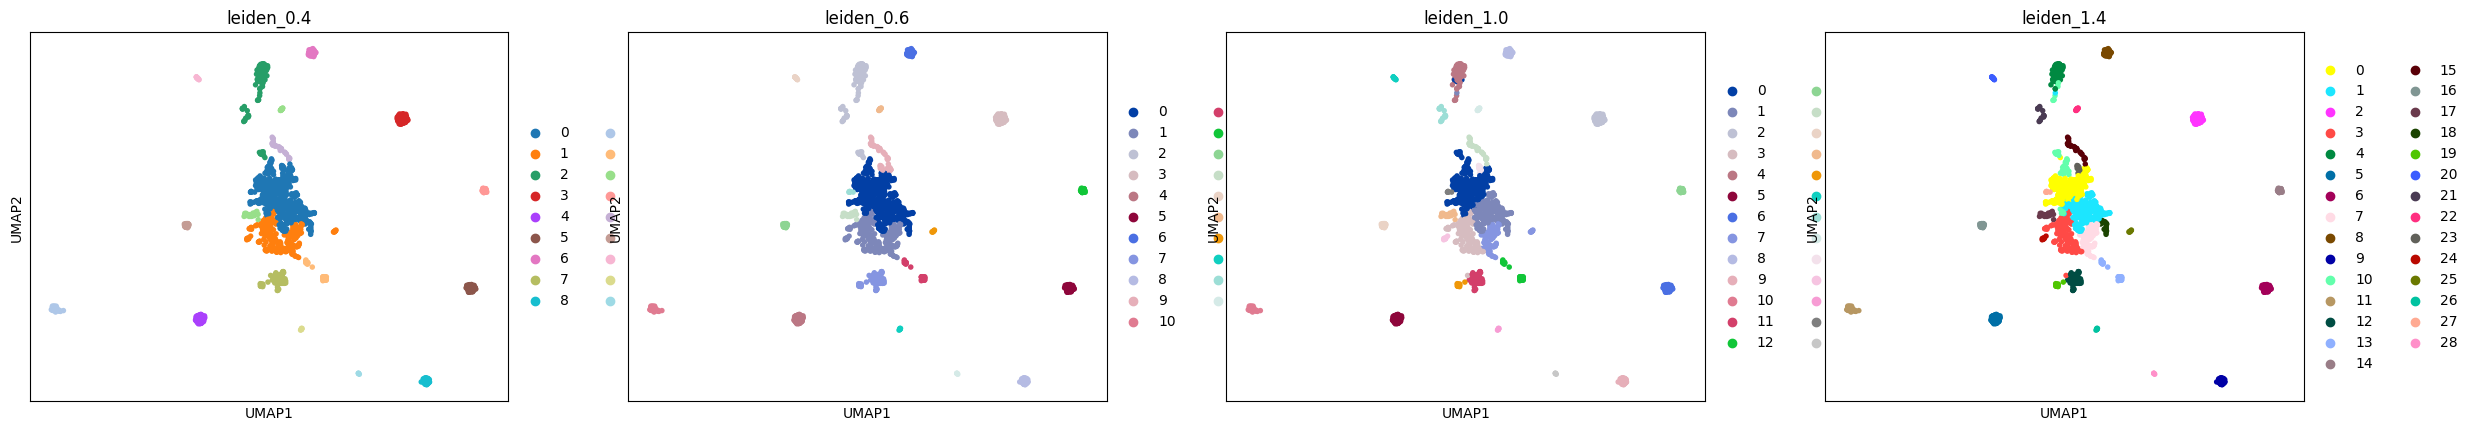

In [79]:
sc.pl.umap(dataset, color=['leiden_0.4', 'leiden_0.6', 'leiden_1.0','leiden_1.4'])

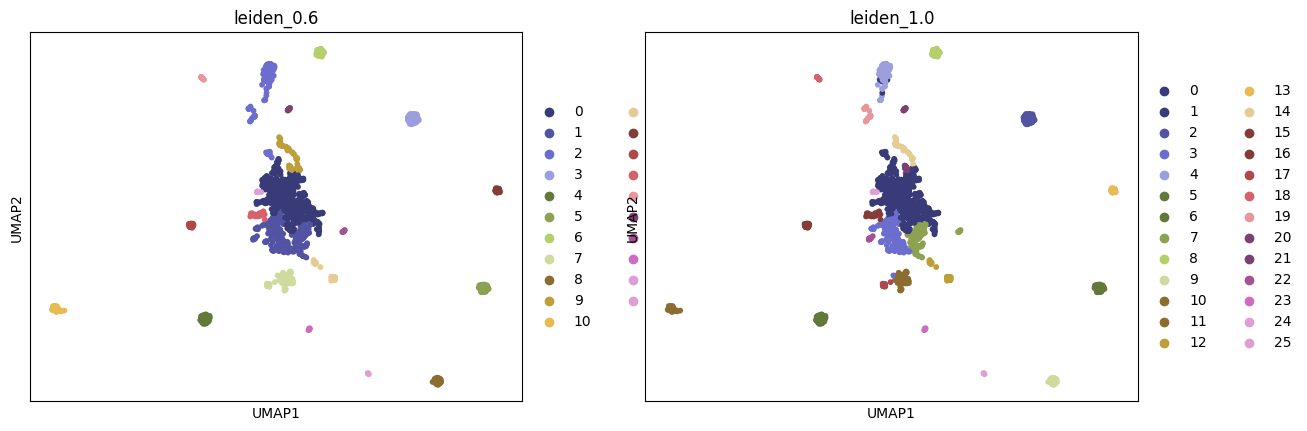

In [98]:
sc.pl.umap(dataset, color=['leiden_0.6', 'leiden_1.0'], palette='tab20b', s=70)

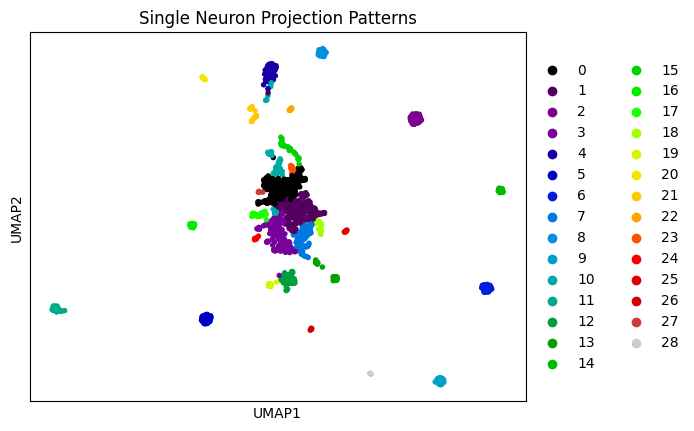

In [133]:
sc.pl.umap(dataset, color=['leiden_1.4'], title='Single Neuron Projection Patterns')


In [125]:
barcodes_across_sample_no_thal_renamed = barcodes_across_sample_renamed[barcodes_across_sample_renamed.index.isin(barcodes_across_sample_no_thal.index)]

In [126]:
dataset.obs['source'] = barcodes_across_sample_no_thal_renamed.idxmax(axis=1)

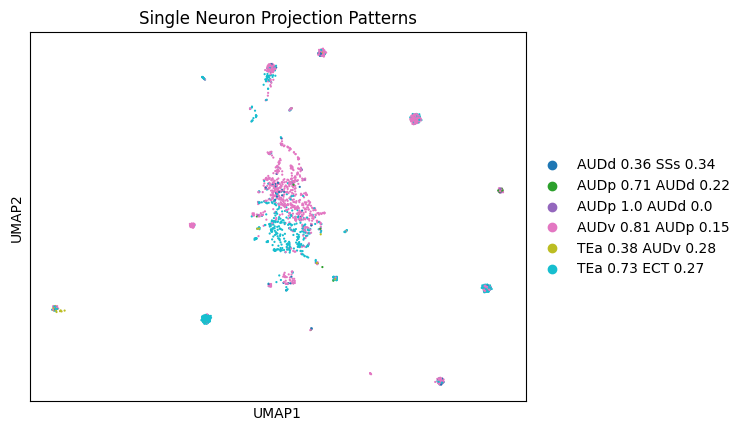

In [92]:
sc.pl.umap(dataset, color=['source'], palette='tab10', s=10, title='Single Neuron Projection Patterns')

In [127]:
leiden_categories = pd.DataFrame(dataset.obs['leiden_1.4'])

In [128]:
source_thresholded_catag = source_thresholded[source_thresholded.index.isin(barcodes_across_sample_no_thal.index)]
source_thresholded_catag['leiden'] = leiden_categories['leiden_0.6']
source_thresholded_catag= source_thresholded_catag.set_index('leiden')


/tmp/ipykernel_119261/897813089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_thresholded_catag['leiden'] = leiden_categories['leiden_1.4']


In [85]:
source_thresholded_catag.to_pickle(normalised_barcode_path.parents[0]/'barcodes_with_leiden_cluster_label_with_all_source.pkl')

In [129]:
barcodes_across_sample_no_thal_no_source= barcodes_across_sample_no_thal.copy()

barcodes_across_sample_no_thal_no_source['leiden'] = leiden_categories['leiden_1.4']
barcodes_across_sample_no_thal_no_source= barcodes_across_sample_no_thal_no_source.set_index('leiden')

In [130]:
barcodes_across_sample_no_thal_no_source.to_pickle(normalised_barcode_path.parents[0]/'barcodes_with_leiden_cluster_label_with_no_source_higher_leiden.pkl')

In [88]:
df = barcodes_across_sample_no_thal_renamed[leiden_categories['leiden_1.0']=='11']
df = df.loc[:, (df != 0).any(axis=0)]
df.loc[:, (df != 0).any(axis=0)]

KeyError: 'leiden_1.0'

In [92]:
leiden_categories = pd.DataFrame(dataset.obs['leiden_1.0'])

In [99]:
barcodes_across_sample_renamed_2 = barcodes_across_sample_no_thal.copy() #note changed from barcodes_across_sample
new_columns= {}
for val in barcodes_across_sample_renamed_2.columns:
    new_columns[val]= all_areas_fractions.loc[val]['name'] #create a dictionary to rename columns in the barcode matrix with tube names rather than RT sample names
barcodes_across_sample_renamed_2 = barcodes_across_sample_renamed_2.rename(columns=new_columns)

In [101]:
df = barcodes_across_sample_renamed_2[leiden_categories['leiden_1.0']=='0']
df = df.loc[:, (df != 0).any(axis=0)]
df.loc[:, (df != 0).any(axis=0)]

,onl 0.64 OLF 0.36,ACAd 0.81 PL 0.14,AId 0.33 CLA 0.23,ACAd 0.82 DP 0.06,ACAd 0.97 ACAv 0.03,MOp 0.45 MOs 0.44,ACAd 0.43 ACAv 0.41,MOp 0.51 MOs 0.46,CP 0.98 ccb 0.01,SSp-tr 0.55 SSp-ll 0.3,...,SCig 0.5 SCiw 0.35,Contra-AUDv 0.43 Contra-or 0.2,PG 0.84 P 0.08,VISp 0.78 RSPd 0.07,ENTl 0.44 VISpor 0.39,PG 0.43 P 0.18,RSPagl 0.51 RSPd 0.23,VISp 0.66 VISl 0.33,ICe 0.47 MB 0.22,ICc 0.4 ICd 0.25
sequence,,,,,,,,,,,,,,,,,,,,,
CATGCTTTATCTTTATATTGTGCACATGACTC,0.0,0.0,0.0,0.000868,0.000325,0.00073,0.000724,0.009277,0.000469,0.00000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
GGTCCCTGTCACCTTGCGTATGCGTCGCTGTT,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00603,...,0.0,0.003823,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
TCCAAGCGCCTGTGCCTCGCAGGCCCAGCTCT,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
GGGGGGCGGAGCCAAATTGTAGTACCTGGGCT,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.0,0.002807,0.0,0.0,0.0,0.0
GCATTATTAAGTGTAAGTTATTCCGCTTCTCC,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.002524,0.004091,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTGAAGTTAACACCAGAACATAAAGGGACGTT,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
GTGATGGGAGTCTGGACTCGGTGTTGAGGTCT,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
GAGTGGCGTCGGATTGTCTACTACGAGGGCCT,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [123]:
bl = pd.DataFrame(areas_to_look.loc[41])
bl = bl[(bl != 0).any(axis=1)]
bl

,41.0
AUDd,0.473159
AUDp,0.004584
AUDpo,0.001222
SSs,0.521035


In [37]:
normalised_with_source['leiden'] = leiden_categories['leiden_1.0']

In [38]:
normalised_with_source = normalised_with_source.set_index('leiden')

In [39]:
normalised_with_source.to_pickle(normalised_barcode_path.parents[0]/'barcodes_with_leiden_cluster_label_with_source.pkl')

Lets try to cluster visual areas only

In [14]:
all_areas_fractions_vis =all_areas_fractions[all_areas_fractions['name'].str.contains('VIS')]
all_areas_fractions_vis = all_areas_fractions_vis[~all_areas_fractions_vis['name'].str.contains('VISC|Contra-VISa|Contra-VISam|Contra-VISC')]

In [23]:
normalised_with_source = barcodes_across_sample.div(barcodes_across_sample.max(axis=1), axis=0)

In [25]:
#now drop source columns
barcodes_normalised_no_source = normalised_with_source.loc[:, (normalised_with_source != 1).all()]

In [26]:
visual_areas_only = barcodes_normalised_no_source[all_areas_fractions_vis.index.values]

In [28]:
dataset =ad.AnnData(visual_areas_only)

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


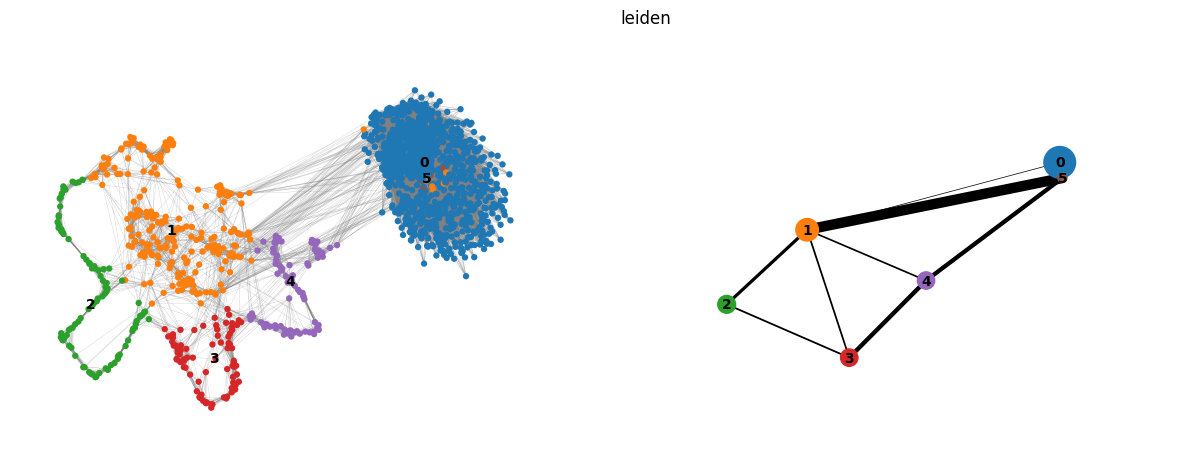

In [30]:
sc.tl.pca(dataset)
sc.pp.neighbors(dataset)
sc.tl.umap(dataset)
sc.tl.leiden(dataset)
sc.tl.paga(dataset)
sc.pl.paga_compare(dataset, edges=True, threshold=0.05)

In [33]:
leiden_categories = pd.DataFrame(dataset.obs['leiden'])

In [34]:
barcodes_across_sample_renamed[leiden_categories['leiden']=='1']

,onl 0.64 OLF 0.36,OLF 0.81 onl 0.19,OLF 0.86 onl 0.14,onl 0.49 MOB 0.28,ACAd 0.81 PL 0.14,ACAd 0.97 MOp 0.03,CP 0.95 fa 0.01,AId 0.33 CLA 0.23,ACAd 0.82 DP 0.06,ACAd 0.97 ACAv 0.03,...,SCiw 0.7 SCdg 0.16,PG 0.43 P 0.18,RSPagl 0.51 RSPd 0.23,VISp 1.0,VISp 1.0,VISp 1.0,VISp 0.66 VISl 0.33,ICe 0.47 MB 0.22,ICc 0.51 ICe 0.27,ICc 0.4 ICd 0.25
sequence,,,,,,,,,,,,,,,,,,,,,
CATGCTTTATCTTTATATTGTGCACATGACTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.030344,1.511072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AATTATTGTTGTGTTATCCAGCTCAACCCCCT,0.0,0.0,0.0,0.0,0.0,1.626345,0.0,0.0,4.030344,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTTCCCAAACACTCGTCTCCATTACTTCACCT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCTTCTGCAACTGAGTTCAACTTTGTTCAGCT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGCACAGGGCCATATGTATGGACAAACTCTTT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGTATCTGTAGAAGGCTGAGTCGGTTGTGATT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GATGATTGCGGCGTCATCTCGTTGCGGGATTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGCCCCATAAATAGTTTGTGCGTGGGCATGTT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
